In [212]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import regex as re
import pathlib
user= 'aolsen'


In [37]:
bayareafips_full = {'06001': 'Alameda', '06013': 'Contra Costa', '06041': 'Marin', '06055': 'Napa',
                    '06075': 'San Francisco', '06081': 'San Mateo', '06085': 'Santa Clara', '06097': 'Sonoma', '06095': 'Solano'}

In [614]:
superdist_to_county = {1: 'San Francisco',
                       2: 'San Francisco',
                       3: 'San Francisco',
                       4: 'San Francisco',
                       5: 'San Mateo',
                       6: 'San Mateo',
                       7: 'San Mateo',
                       8: 'Santa Clara',
                       9: 'Santa Clara',
                       10: 'Santa Clara',
                       11: 'Santa Clara',
                       12: 'Santa Clara',
                       13: 'Santa Clara',
                       14: 'Santa Clara',
                       15: 'Alameda',
                       16: 'Alameda',
                       17: 'Alameda',
                       18: 'Alameda',
                       19: 'Alameda',
                       20: 'Contra Costa',
                       21: 'Contra Costa',
                       22: 'Contra Costa',
                       23: 'Contra Costa',
                       24: 'Contra Costa',
                       25: 'Solano',
                       26: 'Solano',
                       27: 'Napa',
                       28: 'Napa',
                       29: 'Sonoma',
                       30: 'Sonoma',
                       31: 'Sonoma',
                       32: 'Marin',
                       33: 'Marin',
                       34: 'Marin'}

In [41]:
root_dir = '/Users/aolsen/Box/Vital Signs/02_data/RESTRUCTURE/sources/BLS/QCEW/qtrly'

#subfolders_to_exclude = [Path('annual')]

In [42]:
county_str = '({})'.format('|'.join(bayareafips_full.values()))

In [43]:
jurisdictions_2020 = gpd.read_file(filename = f'/Users/{user}/Box/DataViz Projects/Data Services/BASIS/Data Processing/Administrative Boundaries/Jurisdiction Boundaries/TIGER 2020/Jurisdiction_Boundary_Database.gdb',
             layer='Bay_Area_Incorp_Places_Counties_TIGER_2020',driver='FileGDB').rename(columns={'COUNTY':'county','JURISDICTION':'juris'}).to_crs('EPSG:3857')
jurisdictions_2020.county = jurisdictions_2020.county.str.replace(' County','').str.strip()
jurisdictions_2020['juris']=jurisdictions_2020['jurisdicti'] = jurisdictions_2020.juris.str.replace(' town| city','').str.strip()
jurisdictions_2020['area']=jurisdictions_2020.area
jurisdictions_2020['GEOID_PLAC']=jurisdictions_2020.JURISDICTION_GEOID

# recode Uninc to Uninc + County
jurisdictions_2020.loc[jurisdictions_2020.juris.str.contains(
    'Uninc'), 'GEOID_PLAC'] = jurisdictions_2020.loc[jurisdictions_2020.juris.str.contains('Uninc'), 'COUNTY_GEOID']+'UNINC'
jurisdictions_2020.columns = jurisdictions_2020.columns.str.lower()
jurisdictions_2020.crs

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_1692/369373218.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  jurisdictions_2020['juris']=jurisdictions_2020['jurisdicti'] = jurisdictions_2020.juris.str.replace(' town| city','').str.strip()


<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [44]:
# ca_files = list(Path(root_dir).rglob('* 060*.csv'))

# storage = []
# for fn in ca_files:
#     # print(fn)
#     match = re.search(county_str, str(fn))
#     if match:
#         print(str(fn))

#         data = pd.read_csv(str(fn))
#         storage.append(data)

In [378]:
zones_path = f'/Users/{user}/Box/Modeling and Surveys/Urban Modeling/Spatial/Zones/TAZ1454/zones1454.shp'

zones = gpd.read_file(zones_path).to_crs('EPSG:26910')
zones['geom_pt'] = zones.representative_point()
zones['county_name'] = zones.fipsstco.map(bayareafips_full)

zones['region'] = 'Bay Area'

county_x_superdist = zones.groupby(
    ['county_name', 'superdistr']).size().reset_index(1).superdistr

superdistricts = zones.dissolve('superdistr', as_index=False).iloc[:, :2]


In [45]:
pct = lambda x: x/x.sum()

# Naics to land use

In [464]:
def seq_fill(s):
    if len(s) > 1:
        out = np.arange(int(s[0]), 1+int(s[1]))
    else:
        out = s
    return out


luse = pd.read_excel(
    '/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/SF planning land use to NAICS.xlsx', skiprows=1)
luse = luse.dropna(subset=['NAICS'])

# forward fill missing values
luse.Landuse = luse.Landuse.fillna(method='ffill')

# explode comma separated strings
luse_expl_1 = luse.NAICS.astype(str).str.split(',').explode().str.strip()

# then split on hyphens, and use first and second elements range endpoints
luse_expl_2 = luse_expl_1.str.split('-').apply(seq_fill)

# explode on those enumerated ranges, turn to strings
luse_expl_3 = luse_expl_2.explode().astype(str)

# merge back to original DF
naics_to_luse = luse.merge(luse_expl_3, left_index=True,
                           right_index=True).set_index('NAICS_y').Landuse
naics_to_luse[naics_to_luse.index.str.contains('^72')]

NAICS_y
722              Retail
721    Hotel or Visitor
Name: Landuse, dtype: object

# Get QCEW data

In [47]:
from pathlib import Path


def find_matching_files(root_folder, county_names):
    root_path = Path(root_folder)
    matching_files = []

    for file_path in root_path.rglob('* 060*.csv'):
        # Extracting the file name without the extension
        file_name = file_path.stem

        if any(county_name in file_name for county_name in county_names):
            matching_files.append(str(file_path))

    return matching_files

In [ ]:
# Example usage:
root_folder_path = '/Users/aolsen/Box/Vital Signs/02_data/RESTRUCTURE/sources/BLS/QCEW/qtrly'
subfolders_to_exclude = [Path('annual'), Path('qtrly')]

county_names_of_interest = bayareafips_full.values()

matching_files = find_matching_files(root_folder_path, county_names_of_interest)


In [406]:
storage = []
for fn in matching_files:
    data = pd.read_csv(str(fn))
    storage.append(data)

In [407]:
# combine them all
all_data = pd.concat(storage)

In [595]:
# pull out q1

# agglvl_code 70 denotes county level detail, total covered / no industry detail - useful for minimizing
# loss due to non-disclosure avoidance

all_data_county_qtr1 = all_data.query('agglvl_code==70 & qtr==1')
all_data_county_qtr1['county']=all_data_county_qtr1.area_title.str.extract(county_str,expand=False).str.strip()

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_1692/1165130614.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_county_qtr1['county']=all_data_county_qtr1.area_title.str.extract(county_str,expand=False).str.strip()


<AxesSubplot: xlabel='year'>

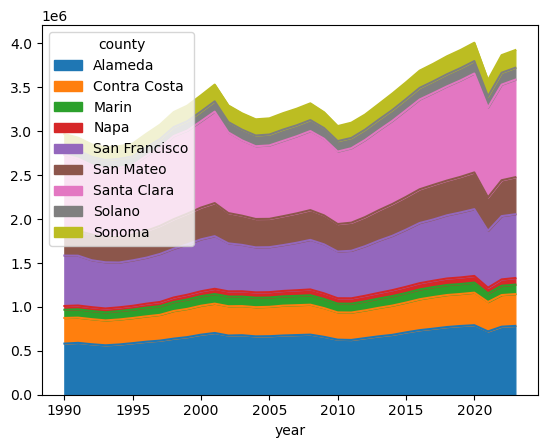

In [596]:
all_data_county_qtr1.set_index(['county','year']).month1_emplvl.unstack(0).plot(kind='area')

## assign land use

In [410]:
# agglvl_code 75 denotes county level detail, naics-3 level detail

all_data_county_naics3_qtr1 = all_data.query('agglvl_code==75 & qtr==1')
all_data_county_naics3_qtr1['county'] = all_data_county_naics3_qtr1.area_title.str.extract(
    county_str, expand=False).str.strip()
all_data_county_naics3_qtr1['land_use'] = all_data_county_naics3_qtr1.industry_code.map(naics_to_luse)

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_1692/3443187969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_county_naics3_qtr1['county'] = all_data_county_naics3_qtr1.area_title.str.extract(
/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_1692/3443187969.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_county_naics3_qtr1['land_use'] = all_data_county_naics3_qtr1.industry_code.map(naics_to_luse)


In [597]:
# get a 2-digit precision naics string

all_data_county_naics3_qtr1['naics_2'] = all_data_county_naics3_qtr1.industry_code.str.slice(0,2)

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_1692/2956018010.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_county_naics3_qtr1['naics_2'] = all_data_county_naics3_qtr1.industry_code.str.slice(0,2)


In [616]:
# make mapping at the two digit level, year specific
naics_to_landuse = (all_data_county_naics3_qtr1.query('year==2015')
                    .groupby(['naics_2', 'land_use'])
                    .month1_emplvl.sum()
                    .groupby(level=['naics_2']).apply(pct)
                    .groupby(level=['naics_2'], group_keys=False).nlargest(1)
                    ).reset_index(1).land_use
naics_to_landuse.head()

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_1692/637698754.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .groupby(level=['naics_2']).apply(pct)


naics_2
11                                  Office
21                                  Office
22    Production/Distribution/Repair (PDR)
23    Production/Distribution/Repair (PDR)
31    Production/Distribution/Repair (PDR)
Name: land_use, dtype: object

In [617]:
# get land use by year, county

county_jobs_by_land_use = all_data_county_naics3_qtr1.groupby(
    ['year', 'county', 'land_use']).month1_emplvl.sum()
county_jobs_by_land_use

year  county   land_use                                
1990  Alameda  Cultural/Institutional/Educational (CIE)     88867
               Hotel or Visitor                              4628
               Office                                      113981
               Private Households                            3542
               Production/Distribution/Repair (PDR)        195822
                                                            ...  
2023  Sonoma   Hotel or Visitor                              4010
               Office                                       42600
               Private Households                             388
               Production/Distribution/Repair (PDR)         55088
               Retail                                       30697
Name: month1_emplvl, Length: 1836, dtype: int64

In [618]:
# get land use by year, county in percent

county_jobs_by_land_use_pct = county_jobs_by_land_use.groupby(level=[0,1]).apply(pct)

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_1692/1270238910.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  county_jobs_by_land_use_pct = county_jobs_by_land_use.groupby(level=[0,1]).apply(pct)


In [619]:
# keep office shares

office_job_shares_by_county = county_jobs_by_land_use_pct.loc[:,:,'Office']

In [620]:
# use these shares, applying them to the total jobs - we do it this way to minimize non-disclosure losses

county_job_estim = all_data_county_qtr1.set_index(
    ['year', 'county']).month1_emplvl.mul(office_job_shares_by_county)


# add regional totals as well
county_job_estim = pd.concat([county_job_estim,
                              pd.concat(
                                  [county_job_estim.sum(
                                      level='year')],
                                  keys=['Region'], names=['county']).reorder_levels([1, 0])])
county_job_estim

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_1692/1833615882.py:10: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  [county_job_estim.sum(


year  county       
1990  Alameda          1.266980e+05
      Contra Costa     7.790542e+04
      Marin            2.568265e+04
      Napa             9.296380e+03
      San Francisco    2.345072e+05
                           ...     
2019  Region           1.254390e+06
2020  Region           1.272374e+06
2021  Region           1.232098e+06
2022  Region           1.328233e+06
2023  Region           1.290506e+06
Name: month1_emplvl, Length: 340, dtype: float64

# Get Costar vacancy data 

Time series from January 2024

In [621]:
costar = pd.read_csv(
    '/Volumes/Data/Models/urban_modeling/data/realestate/costar_office_vacancy_timeseries_jan2024.csv')
costar.sample(2)

,Unnamed: 0,property_class_name,period,slice,as_of,geography_name,property_type,geography_code,forecast_scenario,cbsa_code,...,transaction_sale_pricesf,under_construction_buildings,under_construction_sf,vacancy_rate,vacant_available_,vacant_available_sf,year,msa,submarket_name,county
1944,11071,Office,2007 Q1,All,2024 Q1,San Jose - CA (USA) - Palo Alto,Office,G32988,Base Case,41940,...,425.59,3,166936.0,0.058866,0.054494,521934.0,2007,San Jose,Palo Alto,Santa Clara
966,5011,Office,2001 Q1,All,2024 Q1,San Francisco - CA (USA) - MidMarket,Office,G41755,Base Case,41884,...,91.43,0,NaN,0.084729,0.079704,568673.0,2001,San Francisco,MidMarket,San Francisco


In [622]:
# calculate occupied space

costar['occupied_sf'] = costar.inventory_sf - \
    costar.vacant_available_sf

# summarize by year, county
county_occup_space_estim = costar.groupby(['year', 'county']).occupied_sf.sum()


# add regional totals
county_occup_space_estim = pd.concat([county_occup_space_estim,
                                      pd.concat(
                                          [county_occup_space_estim.sum(
                                              level='year')],
                                          keys=['Region'], names=['county']).reorder_levels([1, 0])])
county_occup_space_estim

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_1692/945407344.py:13: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  [county_occup_space_estim.sum(


year  county       
1997  Alameda           55342619.0
      Contra Costa      32867109.0
      San Francisco    107189020.0
      San Mateo         32085365.0
      Santa Clara       76056093.0
                          ...     
2019  Region           433667830.0
2020  Region           440384974.0
2021  Region           422094270.0
2022  Region           425971947.0
2023  Region           420892400.0
Name: occupied_sf, Length: 230, dtype: float64

Text(2006.5, 320, 'Source: CoStar (occupied office space); QCEW (office jobs)')

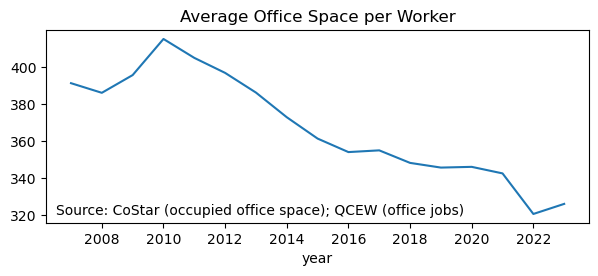

In [623]:
ax=(county_occup_space_estim / county_job_estim).dropna().unstack(1).dropna().Region.plot(figsize=[7,2.5])
ax.set_title('Average Office Space per Worker')
ax.text(2006.5,320,'Source: CoStar (occupied office space); QCEW (office jobs)')

In [624]:
county_job_estim.sort_index().loc[2007:,'Region']/county_job_estim.sort_index().loc[2007,'Region']

year  county
2007  Region    1.000000
2008  Region    1.021983
2009  Region    0.987221
2010  Region    0.928366
2011  Region    0.961549
2012  Region    0.997805
2013  Region    1.039109
2014  Region    1.092076
2015  Region    1.142520
2016  Region    1.194944
2017  Region    1.210466
2018  Region    1.252925
2019  Region    1.281748
2020  Region    1.300124
2021  Region    1.258969
2022  Region    1.357201
2023  Region    1.318651
Name: month1_emplvl, dtype: float64

# Load other employment densities

In [627]:
baus_density_adj = pd.read_csv(
    '/Volumes/Data/Models/urban_modeling/baus/PBA50Plus/PBA50Plus_8a_HE_Pipeline/bayarea_urbansim/configs/adjusters/sqft_per_job_adjusters.csv')
baus_density_adj.set_index(['number','name']).sqft_per_job_factor*359

number  name              
1       SF NE                 435.13672
2       SF NW                 370.08951
3       SF S SE               522.16550
4       SF SW                 608.35422
5       Daly City Millbrae    347.98947
6       San Mateo             330.26205
7       Redwood City          347.98947
8       Palo Alto             330.39488
9       Golden Triangle       320.80958
10      West San Jose         330.39488
11      San Jose CBD          306.44240
12      East San Jose         331.24930
13      South San Jose        347.87100
14      SE Snta Clara Cnty    381.61700
15      Tri Valley            370.12900
16      Fremont               341.05000
17      S Leandro Hayward     347.75253
18      Oakland Alameda       326.18022
19      Berkeley Eville       352.46620
20      Richmond Pinole       347.27147
21      Martinez Concord      347.27147
22      Lamorinda WC          347.51200
23      S Ramon Danville      347.75253
24      East Contra Costa     381.61700
25      Valle

In [628]:
baus_superdist_2015 = pd.read_csv(
    '/Volumes/Data/Models/urban_modeling/baus/PBA50Plus/PBA50Plus_7_Latest_ContingencyPlan_Run_Dev_Pipeline/outputs/pba50_fbp_pr319_v7/geographic_summaries/pba50_fbp_pr319_v7_superdistrict_summary_2010.csv')

In [630]:
BAUS_DENSITY = 359

# baus_density_adj is denoted in adjusters of the base constant, so we multiply by that

baus_density_adj['constant'] = baus_density_adj.sqft_per_job_factor.mul(
    BAUS_DENSITY)
baus_density_adj['county'] = baus_density_adj.number.map(superdist_to_county)
baus_density_adj['totemp'] = baus_density_adj.number.map(
    baus_superdist_2015.set_index('superdistrict').totemp)

baus_density_adj['region'] = 'region'
baus_density_rates = baus_density_adj.groupby('county').apply(
    lambda x: (x.constant*x.totemp).sum()/x.totemp.sum())
baus_density_rates

baus_density_rates_reg = baus_density_adj.groupby('region').apply(
    lambda x: (x.constant*x.totemp).sum()/x.totemp.sum())


In [632]:
baus_density_rates_s = {}
for year in range(2010,2051,5):
    baus_density_rates_s[year] = pd.Series(baus_density_rates)

baus_density_rates_s = pd.concat(baus_density_rates_s)


baus_density_rates_s.index = baus_density_rates_s.index.set_names('year',0)


/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_1692/2295187635.py:8: FutureWarning: In a future version of pandas all arguments of MultiIndex.set_names except for the argument 'names' will be keyword-only.
  baus_density_rates_s.index = baus_density_rates_s.index.set_names('year',0)


In [634]:
density_rates = (county_occup_space_estim /
                 county_job_estim).dropna().reset_index(name='value')
density_rates['variable'] = 'costar/qcew'
# .join(baus_density_rates_s)

In [635]:
baus_basic = pd.Series(BAUS_DENSITY, pd.MultiIndex.from_product([bayareafips_full.values(), range(2010, 2051, 5)], names=['county', 'year'])
                       ).reset_index(name='value')
baus_basic['variable'] = 'PBA50 Constant'

In [636]:
baus_density_rates_df = baus_density_rates_s.reset_index(name='value')
baus_density_rates_df['variable'] = 'PBA50 No Project'
baus_density_rates_df

,year,county,value,variable
0,2010,Alameda,345.257309,PBA50 No Project
1,2010,Contra Costa,352.320457,PBA50 No Project
2,2010,Marin,354.862401,PBA50 No Project
3,2010,Napa,350.391604,PBA50 No Project
4,2010,San Francisco,454.030749,PBA50 No Project
...,...,...,...,...
76,2050,San Francisco,454.030749,PBA50 No Project
77,2050,San Mateo,342.876006,PBA50 No Project
78,2050,Santa Clara,327.568554,PBA50 No Project
79,2050,Solano,377.700326,PBA50 No Project


In [637]:
import pandas as pd

def process_telecommute_data(df, var_str='EN7'):
    # Assuming BAUS_DENSITY is defined somewhere before calling this function

    
    # Filter columns using regex and stack the DataFrame
    baus_tele_adj = df.filter(regex='\d{4}').stack().reset_index(name='value')

    # Extract year from level_1 column and drop the original column
    baus_tele_adj['year'] = baus_tele_adj.level_1.str.extract('(\d{4})', expand=False).astype(int)
    #baus_tele_adj = baus_tele_adj.drop(['level_1'], axis=1)

    # Map 'totemp' and 'county' based on 'number' column
    baus_tele_adj['totemp'] = baus_tele_adj.number.map(baus_superdist_2015.set_index('superdistrict').totemp)
    baus_tele_adj['county'] = baus_tele_adj.number.map(superdist_to_county)

    # Group by 'county' and 'year' and calculate the weighted average
    baus_tele_adj = baus_tele_adj.groupby(['county', 'year']).apply(lambda x: (x.value * x.totemp).sum() / x.totemp.sum()).reset_index(name='value')
    baus_tele_adj['variable'] = var_str

    return baus_tele_adj

# Read the CSV file and multiply by BAUS_DENSITY
baus_tele_adj = pd.read_csv('/Volumes/Data/Models/urban_modeling/baus/PBA50Plus/PBA50Plus_7_Latest_ContingencyPlan_Run_Dev_Pipeline/inputs/plan_strategies/telecommute_sqft_per_job_adjusters.csv', index_col=0)
baus_tele_adj = baus_tele_adj.mul(BAUS_DENSITY)

    
# Example usage with a DataFrame named 'your_dataframe'
baus_tele_adj = process_telecommute_data(baus_tele_adj,var_str='PBA50 Blueprint (EN7)')
baus_tele_adj

,county,year,value,variable
0,Alameda,2015,343.756067,PBA50 Blueprint (EN7)
1,Alameda,2020,342.254190,PBA50 Blueprint (EN7)
2,Alameda,2025,340.754596,PBA50 Blueprint (EN7)
3,Alameda,2030,339.252720,PBA50 Blueprint (EN7)
4,Alameda,2035,337.753126,PBA50 Blueprint (EN7)
...,...,...,...,...
67,Sonoma,2030,385.107261,PBA50 Blueprint (EN7)
68,Sonoma,2035,394.897481,PBA50 Blueprint (EN7)
69,Sonoma,2040,404.690790,PBA50 Blueprint (EN7)
70,Sonoma,2045,414.482207,PBA50 Blueprint (EN7)


In [639]:
file_map = {#'Trend A Reversal': 'sqft_per_job_adjusters_costar_qcew_timevarying_1p1_increase.csv',
            #'Trend B Further reduction': 'sqft_per_job_adjusters_costar_qcew_timevarying_0p9_reduction.csv',
            #'Trend A Alt Reversal (200% envelope)': 'sqft_per_job_adjusters_costar_qcew_timevarying_actual_sd_reversal.csv',
            #'Trend B Alt Further reduction (200% envelope)': 'sqft_per_job_adjusters_costar_qcew_timevarying_actual_sd_continuation.csv',
            'PBA50+: Base2010-20%': 'sqft_per_job_adjusters_costar_qcew_timevarying_base_2010_0p8_reduction.csv',
            'PBA50+: Base2023-20%': 'sqft_per_job_adjusters_costar_qcew_timevarying_base_2023_0p8_reduction.csv',
            'PBA50+: Base2010-10%': 'sqft_per_job_adjusters_costar_qcew_timevarying_base_2010_0p9_reduction.csv',
            'PBA50+: Base2023-10%': 'sqft_per_job_adjusters_costar_qcew_timevarying_base_2023_0p9_reduction.csv',
            'PBA50+: Base2010- 0': 'sqft_per_job_adjusters_costar_qcew_timevarying_base_2010_stasis.csv',
            'PBA50+: Base2023- 0': 'sqft_per_job_adjusters_costar_qcew_timevarying_base_2023_stasis.csv',
            'PBA50+: Base2015-10%-SD':'sqft_per_job_adjusters_costar_qcew_timevarying_base_sd_0p9_reduction.csv',
            'PBA50+: Base2015-20%-SD':'sqft_per_job_adjusters_costar_qcew_timevarying_base_sd_0p8_reduction.csv'}

base_path = '/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/bayarea_urbansim/configs/adjusters'
adjusters = []
for k, v in file_map.items():
    print(k)
    this_adj = pd.read_csv(pathlib.Path(base_path, v), index_col=[0])

    this_adj_long = process_telecommute_data(
        this_adj, var_str=k)

    this_adj_long.value = this_adj_long.value.mul(BAUS_DENSITY)
    adjusters.append(this_adj_long)

PBA50+: Base2010-20%
PBA50+: Base2023-20%
PBA50+: Base2010-10%
PBA50+: Base2023-10%
PBA50+: Base2010- 0
PBA50+: Base2023- 0
PBA50+: Base2015-10%-SD
PBA50+: Base2015-20%-SD


In [640]:
combo_adjusters = pd.concat(adjusters)
combo_adjusters

,county,year,value,variable
0,Alameda,2015,345.257309,PBA50+: Base2010-20%
1,Alameda,2020,345.257309,PBA50+: Base2010-20%
2,Alameda,2025,327.994443,PBA50+: Base2010-20%
3,Alameda,2030,293.468712,PBA50+: Base2010-20%
4,Alameda,2035,276.205847,PBA50+: Base2010-20%
...,...,...,...,...
67,Sonoma,2030,316.656076,PBA50+: Base2015-20%-SD
68,Sonoma,2035,298.029248,PBA50+: Base2015-20%-SD
69,Sonoma,2040,298.029248,PBA50+: Base2015-20%-SD
70,Sonoma,2045,298.029248,PBA50+: Base2015-20%-SD


In [641]:
everything_density = pd.concat([combo_adjusters,
                                baus_tele_adj, baus_density_rates_df, density_rates, baus_basic])
everything_density[everything_density.variable.str.contains('qcew')]

,county,year,value,variable
0,Alameda,1997,382.290679,costar/qcew
1,Contra Costa,1997,376.671650,costar/qcew
2,Region,1997,339.171257,costar/qcew
3,San Francisco,1997,475.263365,costar/qcew
4,San Mateo,1997,337.651059,costar/qcew
...,...,...,...,...
225,San Francisco,2023,300.747755,costar/qcew
226,San Mateo,2023,333.257572,costar/qcew
227,Santa Clara,2023,353.666202,costar/qcew
228,Solano,2023,296.742364,costar/qcew


In [584]:
everything_density.to_csv('/Volumes/Data/Models/urban_modeling/baus/PBA50Plus_Development/Exogenous/review/combined_data/updated/everything_density.csv')

In [585]:
# [print(f) for f in everything_density.query('variable.str.contains("Future")').variable.unique()]

In [586]:
# everything_density.query('variable.str.contains("Alt")').set_index(['county','year','variable']).value.unstack(2)

# Sandbox
## LODES data

In [384]:
censusblocks = gpd.read_file('/Users/aolsen/Dropbox/Documents/Data/GIS/Census/blocks/2010/blocks_bayarea_2010_geoid.shp')
censusblocks['geom_pt']=censusblocks.representative_point()

In [385]:
blocks_x_superdist = gpd.sjoin(censusblocks.set_geometry('geom_pt'),superdistricts)

In [364]:
schema = pd.read_excel('/Users/aolsen/Box/Vital Signs/02_data/RESTRUCTURE/sources/CENSUS/LODES/schemas.xlsx',sheet_name='WAC',skiprows=1)
wac_indus_map = schema.query('varcat=="industry"').set_index('Variable').shortname

In [390]:
cageos = pd.read_csv('/Users/aolsen/Box/Vital Signs/02_data/RESTRUCTURE/sources/CENSUS/LODES/ca_xwalk.csv',dtype=str)
#cageos['place_recode']=cageos.stplc.map(places_to_counties.set_index('geoid').place_recode)
cageos['juris']=cageos.stplcname.str.replace(', CA','').str.replace(
    ' city| town', '').str.strip()

cageos['county'] = cageos.ctyname.str.replace(' County, CA','').str.strip()
cageos['superdistrict'] = cageos.tabblk2010.map(blocks_x_superdist.set_index('GEOID10').superdistr)

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_1692/1787156948.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  cageos['juris']=cageos.stplcname.str.replace(', CA','').str.replace(


In [391]:
cageos['place_recode'] = cageos.stplcname
cageos_uninc_mask = cageos.stplc=="9999999"
cageos.loc[cageos_uninc_mask,'place_recode'] = 'Unincorporated ' + cageos.loc[cageos_uninc_mask,'county']

In [333]:
import glob
LEHD_PATH = '/Users/aolsen/Box/Vital Signs/02_data/RESTRUCTURE/sources/CENSUS/LODES/JT00/*csv'

In [334]:
lehd_files = {}
for fpth in glob.glob(LEHD_PATH):
    fname = fpth.split('/')[-1]
    print(fname)

    year = re.search('(?P<year>\d{4})',fname).group('year')
    lehd_files[int(year)]=pd.read_csv(fpth,dtype={'w_geocode':str})

ca_wac_S000_JT00_2002.csv
ca_wac_S000_JT00_2003.csv
ca_wac_S000_JT00_2004.csv
ca_wac_S000_JT00_2005.csv
ca_wac_S000_JT00_2006.csv
ca_wac_S000_JT00_2007.csv
ca_wac_S000_JT00_2008.csv
ca_wac_S000_JT00_2009.csv
ca_wac_S000_JT00_2010.csv
ca_wac_S000_JT00_2011.csv
ca_wac_S000_JT00_2012.csv
ca_wac_S000_JT00_2013.csv
ca_wac_S000_JT00_2014.csv
ca_wac_S000_JT00_2015.csv
ca_wac_S000_JT00_2016.csv
ca_wac_S000_JT00_2017.csv
ca_wac_S000_JT00_2018.csv
ca_wac_S000_JT00_2019.csv


In [392]:
lehd_data = pd.concat(lehd_files,names=['year','oid']).reset_index('oid',drop=True)

lehd_data['juris'] = lehd_data.w_geocode.map(
    cageos.set_index('tabblk2010').place_recode)
lehd_data['county'] = lehd_data.w_geocode.map(cageos.set_index(
    'tabblk2010').ctyname).str.replace(' County, CA', '')
lehd_data['superdistrict'] = lehd_data.w_geocode.map(cageos.set_index(
    'tabblk2010').superdistrict)

In [ ]:
# any counties missing?
lehd_data[lehd_data.county.isna()]

# subset to bay area
lehd_data_bayarea = lehd_data[lehd_data.county.isin(bayareafips_full.values())]

#lehd_data_bayarea[lehd_data_bayarea.subregion.isna()]

lehd_data_bayarea = lehd_data_bayarea.set_index(['w_geocode','juris','county','superdistrict'],append=True).rename(columns=wac_indus_map)[wac_indus_map]
lehd_data_bayarea.columns = lehd_data_bayarea.columns.str.replace('emp_indus_','').str.slice(0,2)

In [478]:
lehd_data_bayarea_landuse = lehd_data_bayarea.copy()
lehd_data_bayarea_landuse.columns = lehd_data_bayarea_landuse.columns.map(naics_to_landuse)
lehd_data_bayarea_landuse.columns = lehd_data_bayarea_landuse.columns.set_names('landuse')
lehd_data_bayarea_landuse = lehd_data_bayarea_landuse.groupby(axis=1,level=0).sum()

lehd_data_bayarea_landuse = lehd_data_bayarea_landuse.groupby(level=['year','county','superdistrict']).sum().stack().reset_index(name='value')
lehd_data_bayarea_landuse.to_excel('/Users/aolsen/Downloads/lehd_data_bayarea_landuse.xlsx')

In [444]:
lehd_data_bayarea.groupby(level=['year', 'county', 'superdistrict']).sum().loc(0)[
    :, 'San Francisco']

11  21    22     23    31    42     44  \
year county        superdistrict                                            
2002 San Francisco 1.0            271  10  2567   6540  6156  7094  21213   
                   2.0             19   3    68   1491   379   785   8015   
                   3.0             50   1  3146   8526  7152  5047   9443   
                   4.0              3   0    46   1013   327   232   3954   
2003 San Francisco 1.0            268   8  5582   5012  5651  6987  23253   
...                               ...  ..   ...    ...   ...   ...    ...   
2018 San Francisco 4.0             31   1     0   1583   251   132   3210   
2019 San Francisco 1.0             85   7  7922   9605  6466  9172  22147   
                   2.0             70   0    90   1761   751   885   8095   
                   3.0             33   0  3948  11766  4925  4591  11140   
                   4.0             68   0     0   1442   223   153   2891   

                                     48     51     52     53      54     55  \
year county        superdistrict                                              
2002 San Francisco 1.0             2841  15636  41252   8664   51178  17419   
                   2.0              670   1394   1516   2385    3568    946   
                   3.0            13932   4083   1680   1886    5921   1702   
                   4.0               62    158   1040    351     765     86   
2003 San Francisco 1.0             3077  13312  39344   8294   46947  13528   
...                                 ...    ...    ...    ...     ...    ...   
2018 San Francisco 4.0              307     96    866    499    1669     39   
2019 San Francisco 1.0            15224  42246  43438  11600  116565  18372   
                   2.0              662   2063   2399   1845    6159    944   
                   3.0            14132   6191   1895   2355   18682   1949   
                   4.0              318    115    823    382    1717     69   

                                     56     61     62    71     72     81  \
year county        superdistrict                                            
2002 San Francisco 1.0            24821   4961  10824  4987  36448  15593   
                   2.0             1976  13160  17528  4280  10161   6913   
                   3.0            17310  16400  14891  3045   8146   7147   
                   4.0              606   1204   2006   356   2521   2205   
2003 San Francisco 1.0            25239   5963  10773  5286  36428  16025   
...                                 ...    ...    ...   ...    ...    ...   
2018 San Francisco 4.0              416   7400   6024   882   4436   1528   
2019 San Francisco 1.0            33805  10501  30099  7183  47706  15190   
                   2.0             2565  11967  29099  4571  14936   7188   
                   3.0             6224  26195  27213  5504  15538   7397   
                   4.0              508   7091   6313   825   4440   1605   

                                     92  
year county        superdistrict         
2002 San Francisco 1.0              442  
                   2.0              790  
                   3.0            16259  
                   4.0                0  
2003 San Francisco 1.0              484  
...                                 ...  
2018 San Francisco 4.0                6  
2019 San Francisco 1.0            13662  
                   2.0             5122  
                   3.0            10045  
                   4.0                4  

[72 rows x 20 columns]